In [159]:
!pip install coincheck

In [24]:
import json
f=open("keys.json","r")
g=json.load(f)
secret_key=g["secret_key"]
access_key=g["access_key"]
line_notify_token=g["line_notify_token"]

In [147]:
#過去のレートを取得する(dtはdatetime型)dtの時のレート
import datetime
import requests
import json
def pastrate(pair,dt):
    URL = 'https://coincheck.com/ja/exchange/rates/search'
    t=datetime.timedelta(hours=9)
    dt-=t
    dt=str(dt)
    a,b=dt.split()
    time="{}T{}.000Z".format(a,b)
    res=requests.get(URL,params={"pair":pair,"time":time}).json()
    return float(res["rate"]),res["time"]

In [233]:
#~~T~~Zの形を、datetime型に変える
def henkan(s):
    s=s[:-1].split("T")
    a=s[0].split("-")
    b=s[1].split(":")
    c=b[-1].split(".")
    dt=datetime.datetime(int(a[0]), int(a[1]), int(a[2]), 
                         int(b[0]), int(b[1]), int(c[0]), int(c[1].zfill(1)+"000"))
    dt+=datetime.timedelta(hours=9)
    return dt

In [250]:
def henkan1(s):
    dt=str(s)
    a,b=dt.split()
    time="{}T{}.000Z".format(a,b)
    return time

In [148]:
#データを指定したpair,回数,間隔でとってきて作る
import datetime
import pandas as pd
def mkdata(pair,n,days=0,hours=0,minutes=0):
    t=datetime.timedelta(days=days,hours=hours,minutes=minutes)
    dt=datetime.datetime.now()
    data=[]
    tdata=[]
    for i in range(1,n+1):
        dt1=dt-(n-i)*t
        rate,time=pastrate(pair,dt1)
        data.append(rate)
        tdata.append(time)
    ans={"time":tdata,"rate":data}
    ans=pd.DataFrame(ans)
    return ans

In [149]:
#n日移動平均を足す
def mv(data,n):
    data["mv"+str(n)]=data["rate"].rolling(n).mean()
    return data

In [150]:
#n日のrsiを追加
def rsi(data,n):
    diff=data["rate"].diff()
    up=diff.copy()
    down=diff.copy()
    up[up<0]=0
    down[down>0]=0
    up=up.rolling(n).mean()
    down=down.abs().rolling(n).mean()
    data["rsi"]=up/(up+down)*100
    return data

In [151]:
#kσ区間のボリンジャーバンドn個の標準偏差を用いる
def bband(data,n=20,k=2):
    mean=data["rate"].rolling(n).mean()
    std=data["rate"].rolling(n).std()
    data["bbup"]=mean+(std*k)
    data["bbdown"]=mean-(std*k)
    return data

In [152]:
#n個前からの線形回帰
from sklearn.linear_model import LinearRegression
import numpy as np

def liner(data,n=len(data)):
    t=np.array(data["rate"])
    x=np.arange(n).reshape(-1, 1)
    result=LinearRegression().fit(x,t[len(data)-n:].reshape(-1, 1))
    a=result.coef_[0][0]
    b=result.intercept_[0]
    y=[]
    for i in range(n):
        y.append(a*i+b)
    data["liner"]=pd.Series(y,index=[len(data)-n+i for i in range(n)])
    return data

In [244]:
import matplotlib.pyplot as plt
def bunseki(pair,data):
    data=mv(data,3)
    data=mv(data,7)
    data=rsi(data,7)
    data=bband(data,20)
    data=liner(data,100)
    return data

In [196]:
#残高(balance),未解決の買い(jpy)売り(その他)注文に利用している合計
from coincheck import account
def getinfo(secret_key,access_key):
    a = account.Account(secret_key=secret_key, access_key=access_key)
    s=a.get_balance()
    dic={"name":['jpy','btc','eth','etc',
                 'lsk','fct','xrp','xem',
                 'ltc','bch','mona','xlm',
                 'qtum','bat','iost','enj'],
         "balance":[s['jpy'],s['btc'],s['eth'],s['etc'],
                 s['lsk'],s['fct'],s['xrp'],s['xem'],s['ltc'],
                 s['bch'],s['mona'],s['xlm'],s['qtum'],
                 s['bat'],s['iost'],s['enj']],
        "reserved":[s['jpy_reserved'],s['btc_reserved'],s['eth_reserved'],s['etc_reserved'],
                    s['lsk_reserved'],s['fct_reserved'],s['xrp_reserved'],s['xem_reserved'],
                    s['ltc_reserved'],s['bch_reserved'],s['mona_reserved'],s['xlm_reserved'],
                    s['qtum_reserved'],s['bat_reserved'],s['iost_reserved'],s['enj_reserved']]}
    dic=pd.DataFrame(dic)
    return dic

In [202]:
import requests
def note(line_notify_token,message):
    line_notify_token = line_notify_token
    line_notify_api = 'https://notify-api.line.me/api/notify'
    payload = {'message': message}
    headers = {'Authorization': 'Bearer ' + line_notify_token} 
    return requests.post(line_notify_api, data=payload, headers=headers)

In [ ]:
def buy(f,t,rate,amount):
    o = order.Order(secret_key=secret_key,access_key=access_key)
    

In [197]:
getinfo(secret_key,access_key)

,name,balance,reserved
0,jpy,10000.0,0.0
1,btc,0,0.0
2,eth,0,0.0
3,etc,0,0.0
4,lsk,0,0.0
5,fct,0,0.0
6,xrp,0,0.0
7,xem,0,0.0
8,ltc,0,0.0
9,bch,0,0.0


In [234]:
s1="2021-02-08T11:35:47.005Z"
s=s1[:-1].split("T")
print(s)
a=s[0].split("-")
b=s[1].split(":")
print(a)
print(b)
print(henkan(s1))

['2021-02-08', '11:35:47.005']
['2021', '02', '08']
['11', '35', '47.005']
2021-02-08 11:35:47.005000


In [251]:
data2=mkdata("btc_jpy",2,minutes=5)
print(data2)
data2.loc[2]=["098"]
print(data2)

                       time       rate
0  2021-02-08T14:15:54.045Z  4526099.0
1  2021-02-08T14:20:54.045Z  4526099.0


ValueError: cannot set a row with mismatched columns

<AxesSubplot:>

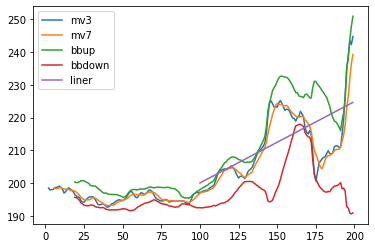

In [253]:
data1=mkdata("lsk_jpy",200,minutes=5)
data1=bunseki("lsk_jpy",data1)
data1.plot(y=["mv3","mv7","bbup","bbdown","liner"])

In [203]:
message = 'テスト通知'
note(line_notify_token,message)

<Response [200]>

In [235]:
d=mkdata("btc_jpy",3,minutes=5)
print(d["time"][len(d)-1])
print(len(d)-1)

2021-02-08T12:14:30.239Z
2


In [ ]:
#与えられたpair,データ数,間隔で分析する
def go(pair,n,days=0,hours=0,minutes=0):
    data=mkdata(pair,n,days=days,hours=hours,minutes=minutes)
    next_time=data["time"][len(d)-1]+datetime.timedelta(days=days,hours=hours,minutes=minutes)
    while True:
        next_list=[]
        next_list.append(henkan1(next_time))
        next_list.append
        